In [114]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Load the trained models
autoencoder = load_model('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/autoencoder_model_final.h5')
cnn = load_model('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/cnn_model_final.h5')
lstm = load_model('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/lstm_model_final.h5')

# Load and preprocess the test data (replace 'test_data.csv' with your test data file path)
test_data = pd.read_csv('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/Testing_Final.csv')  



/var/folders/g5/99t7y6l16nld30m4l79m3pzw0000gn/T/ipykernel_56386/1948815527.py:12: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/Testing_Final.csv')


In [115]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import joblib
from sklearn.metrics import classification_report

# Function to handle missing values (same as in your training script)
def handle_nan_values(df):
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df.fillna(df.mean(), inplace=True)

# Function to create sequences for LSTM (same as in your training script)
def create_sequences(X, y, sequence_length):
    sequences = []
    labels = []
    for i in range(len(X)):
        if i < sequence_length - 1:
            pad_length = sequence_length - 1 - i
            padded_sequence = np.zeros((sequence_length, X.shape[1]))
            padded_sequence[pad_length:] = X[:i+1]
            sequences.append(padded_sequence)
            labels.append(y[i])
        else:
            seq = X[i - sequence_length + 1:i + 1]
            sequences.append(seq)
            labels.append(y[i])
    return np.array(sequences), np.array(labels)

# Load the test data
test_data = pd.read_csv('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/Testing_Final.csv')

# Preprocess the test data
handle_nan_values(test_data)
test_data = pd.get_dummies(test_data, columns=['CountyName', 'Ecosystem'])

# Align features in test data
test_features = test_data.drop(['date', 'Fire'], axis=1)

# Load feature names with allow_pickle set to True
feature_names = np.load('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/feature_names.npy', allow_pickle=True)

# Add missing columns in test set
missing_cols = set(feature_names) - set(test_features.columns)
for c in missing_cols:
    test_features[c] = 0

# Remove extra columns in test set
extra_cols = set(test_features.columns) - set(feature_names)
test_features = test_features.drop(columns=extra_cols)

# Ensure the order of feature columns in test data is the same as in training data
test_features = test_features[list(feature_names)]

# Normalize the features
scaler = joblib.load('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/scaler_final.gz')
X_test = scaler.transform(test_features)

# Load the trained models
autoencoder = load_model('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/autoencoder_model_final.h5')
cnn = load_model('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/cnn_model_final.h5')
lstm_model = load_model('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/lstm_model_final.h5')

# Predict with autoencoder
predictions_autoencoder = autoencoder.predict(X_test)

# Aggregate the autoencoder's output
autoencoder_final_predictions = np.mean(predictions_autoencoder, axis=1)

# Define the encoder part of autoencoder for CNN input
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_1').output)

# Encode and reshape test data for CNN input
encoded_X_test = encoder_model.predict(X_test)
reshaped_dim = int(np.sqrt(64))  # 8x8 grid
reshaped_X_test = encoded_X_test.reshape(-1, reshaped_dim, reshaped_dim, 1)

# Predict with CNN
cnn_predictions = cnn.predict(reshaped_X_test)
cnn_final_predictions = cnn_predictions.flatten()

# Create sequences and predict with LSTM
X_test_seq, _ = create_sequences(X_test, np.zeros(len(X_test)), 14)  # Assuming no labels for test set
lstm_predictions = lstm_model.predict(X_test_seq)
lstm_final_predictions = lstm_predictions[:, -1]

# Combine the predictions
predictions_ensemble = (autoencoder_final_predictions + cnn_final_predictions + lstm_final_predictions) / 3
ensemble_binary_predictions = (predictions_ensemble > 0.4).astype(int)

# Extract true labels
Y_test = test_data['Fire'].values

# Evaluate the ensemble model
print(classification_report(Y_test, ensemble_binary_predictions))


/var/folders/g5/99t7y6l16nld30m4l79m3pzw0000gn/T/ipykernel_56386/3914895240.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('/Volumes/LaCie/Deep_Learning_Final_Project/Machine/Testing_Final.csv')
/var/folders/g5/99t7y6l16nld30m4l79m3pzw0000gn/T/ipykernel_56386/3914895240.py:12: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


1830/1830 [==============================] - 2s 981us/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     57642
           1       0.67      0.45      0.54       899

    accuracy                           0.99     58541
   macro avg       0.83      0.72      0.76     58541
weighted avg       0.99      0.99      0.99     58541



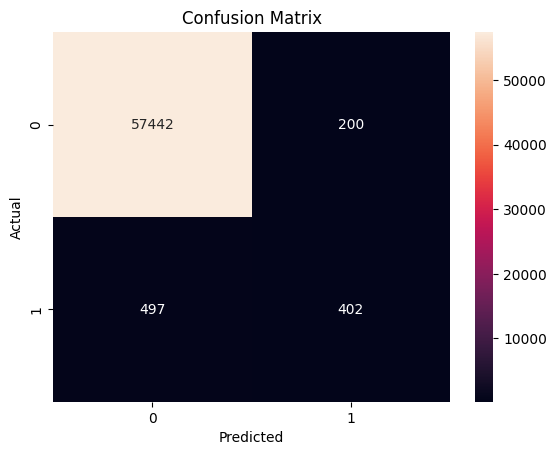

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(Y_test, ensemble_binary_predictions.round())


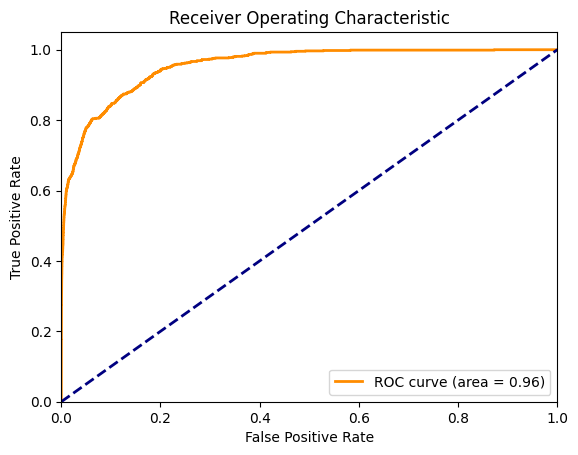

In [117]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(Y_test, predictions_ensemble)


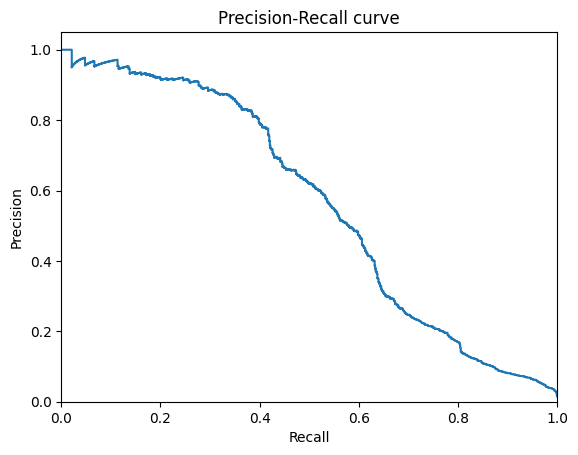

In [118]:
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

plot_precision_recall_curve(Y_test, predictions_ensemble)


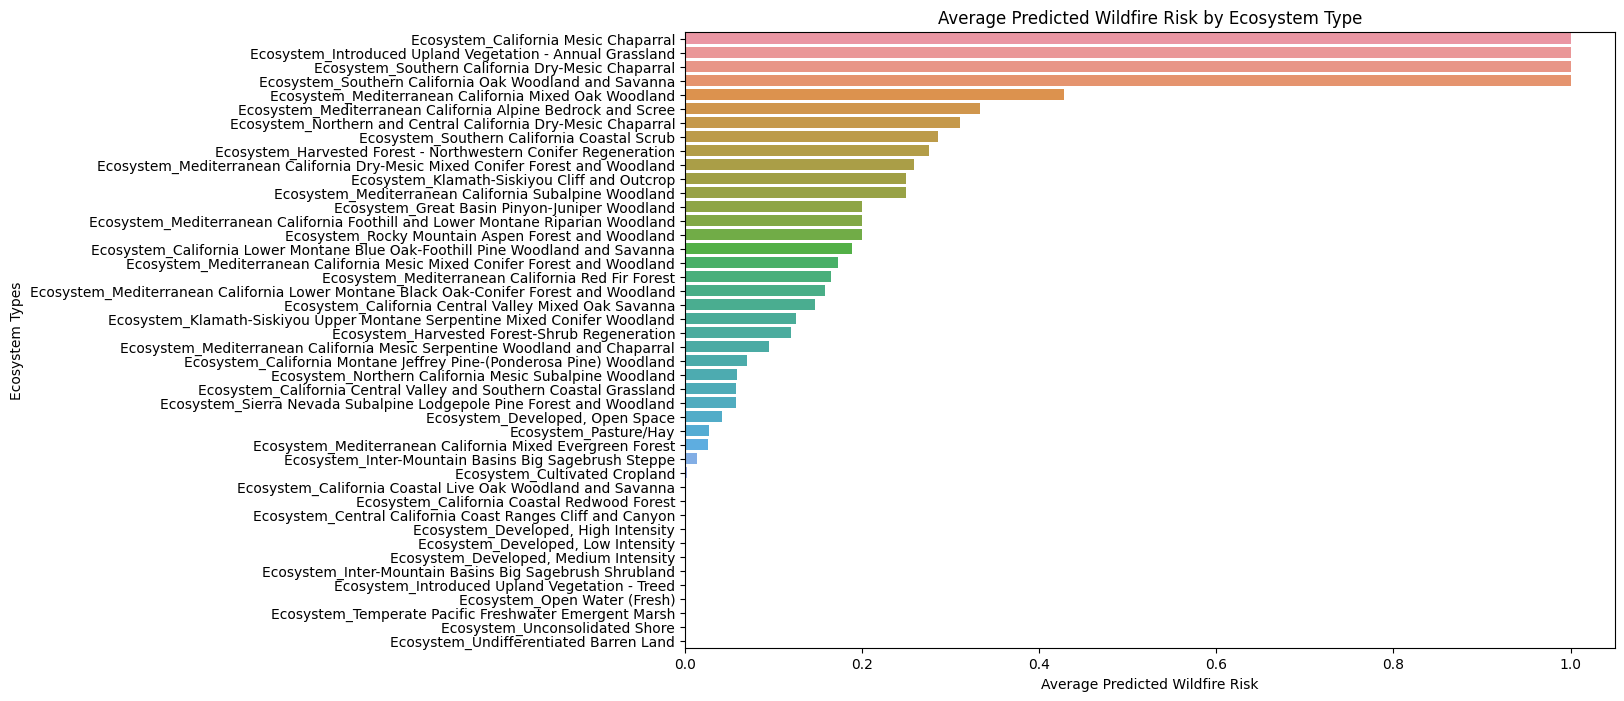

In [120]:
# Assuming 'Ecosystem' dummy variables are prefixed with 'Ecosystem_' in your test data
# First, we extract the names of all ecosystem columns
ecosystem_columns = [col for col in test_data.columns if col.startswith('Ecosystem_')]

# Now, we can calculate the average predicted risk for each type of ecosystem
ecosystem_risks = {}
for eco in ecosystem_columns:
    # We use the ensemble_binary_predictions for calculating the average risk
    average_risk = test_data.loc[test_data[eco] == 1, 'Ensemble_FireRisk'].mean()
    ecosystem_risks[eco] = average_risk

# Sort ecosystems by risk and create a bar plot
sorted_ecosystem_risks = dict(sorted(ecosystem_risks.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(12, 8))
sns.barplot(x=list(sorted_ecosystem_risks.values()), y=list(sorted_ecosystem_risks.keys()))
plt.xlabel('Average Predicted Wildfire Risk')
plt.ylabel('Ecosystem Types')
plt.title('Average Predicted Wildfire Risk by Ecosystem Type')
plt.show()


In [119]:
# Create an interavtive map with Folium, that shows the predictions of the model. 

import folium
import geopandas as gpd
import pandas as pd
import numpy as np

# Add ensemble predictions to the test data
test_data['Ensemble_FireRisk'] = ensemble_binary_predictions

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(test_data, geometry=gpd.points_from_xy(test_data['Longitude'], test_data['Latitude']))

# Define color function
def color_producer(val):
    if val == 1:
        return 'red'  # High risk
    else:
        return 'green'  # Low risk

# Create a map centered around the average location in your data
m = folium.Map(location=[gdf['Latitude'].mean(), gdf['Longitude'].mean()], zoom_start=6)

# Add points to the map
for idx, row in gdf.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=5,
        color=color_producer(row['Ensemble_FireRisk']),
        fill=True,
        fill_color=color_producer(row['Ensemble_FireRisk']),
        fill_opacity=0.7
    ).add_to(m)

# Save map to an HTML file
output_path = '/Volumes/LaCie/Deep_Learning_Final_Project/Machine/Ensemble_FireRisk_Map_Final.html'
m.save(output_path)
print(f"Map saved to {output_path}")


Map saved to /Volumes/LaCie/Deep_Learning_Final_Project/Machine/Ensemble_FireRisk_Map_Final.html
